In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import expon, sem

### 4c
Consider a lookback put option with floating strike price and maturity $T$,
whose payoff is
$$ X = \max_{0 \leq t \leq T} S_t - S_T. $$

(a) Write a function to estimate the price of this lookback option, where the
maximum of the stock price is estimated with
$$ \max(S_{t_0}, S_{t_1}, ..., S_{t_M}) $$
for some $0 = t_0 < t_1 < \cdots < t_m = T.$ Let the input of the function be
$$ S_0, r, \sigma, T, m, (t_0, ..., t_m), n, $$
where $n$ is the sample size. Is the estimate unbiased? If it is not, is the bias positive or negative?

(b) Write a function that yields an unbiased estimate for the price of the
lookback put option. The input of the function should be $S_0, r, T, \sigma, n$.
Hint: Use Exercise 4.7 (a) and Lemma 2.2, or use Exercise 4.7 (c).

(c) Report your estimates and standard errors from (a) and (b) with the
parameters given by
$$S_0 = 20, r = 0.03, \sigma = 0.2, T = 0.5, n = 10000. $$
For part (a) let $t_0 = i T / m$ and $m = 10, 100, 1000$ respectively.

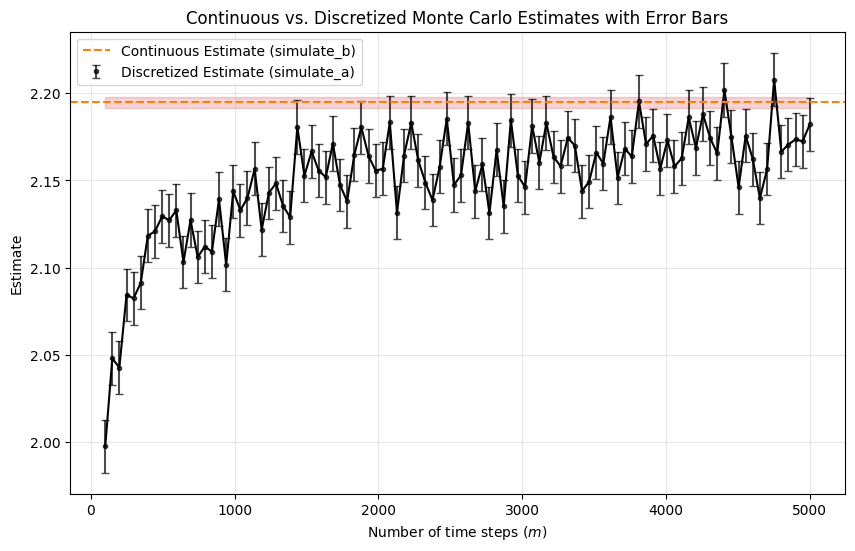

In [9]:
# Setup
np.random.seed(4198)

# Simulation parameters
S_0, r, sig, T = 20, 0.03, 0.2, 0.5
n = 10_000

def simulate_a(m):
    """Discretized simulation with m time steps."""
    dt = T / m
    Z = np.random.normal(size=(m, n))
    st = np.zeros(shape=(m + 1, n))

    st[0, :] = S_0
    for i in range(1, m + 1):
        dW = np.sqrt(dt) * Z[i - 1, :]
        st[i, :] = st[i - 1, :] * np.exp((r - 0.5 * sig**2) * dt + sig * dW)

    payoff = np.maximum(np.max(st, axis=0) - st[-1], 0)
    discounted_payoff = np.exp(-r * T) * payoff

    est = np.mean(discounted_payoff)
    se = sem(discounted_payoff)

    return est, se

def simulate_b():
    """Continuous simulation using exact distribution."""
    N = n * 100
    W = np.random.normal(size=N)
    S_T = S_0 * np.exp((r - 0.5 * sig**2) * T + sig * np.sqrt(T) * W)

    x = np.log(S_T) - np.log(S_0)
    y = expon.rvs(scale=1.0, size=N)
    max_X_t = 0.5 * (x + np.sqrt(x**2 + 2 * sig**2 * T * y))

    payoff = np.maximum(S_0 * np.exp(max_X_t) - S_T, 0)
    discounted_payoff = np.exp(-r * T) * payoff

    est = np.mean(discounted_payoff)
    se = sem(discounted_payoff)

    return est, se

# Store results for plotting
m_values = np.linspace(100, 5000, 100, dtype=int)
est_a_vals, se_a_vals = [], []

# Run simulate_b once
mean_est_b, se_b = simulate_b()

# Collect simulate_a values across m
for m in m_values:
    mean_est_a, se_a = simulate_a(m)
    est_a_vals.append(mean_est_a)
    se_a_vals.append(se_a)

# Plot results
plt.figure(figsize=(10, 6))

# Discretized (simulate_a) with error bars + line
plt.errorbar(
    m_values, est_a_vals, yerr=se_a_vals, fmt="o", markersize=3, capsize=3,
    color='black',
    label="Discretized Estimate (simulate_a)", alpha=0.7
)
plt.plot(m_values, est_a_vals, linestyle="-", color="black")

# Continuous (simulate_b) as single horizontal line with band
plt.axhline(mean_est_b, color="tab:orange", linestyle="--", label="Continuous Estimate (simulate_b)")
plt.fill_between(m_values, mean_est_b - 1.96 * se_b, mean_est_b + 1.96 * se_b, color="tab:red", alpha=0.2)

plt.xlabel("Number of time steps ($m$)")
plt.ylabel("Estimate")
plt.title("Continuous vs. Discretized Monte Carlo Estimates with Error Bars")

plt.legend()
plt.grid(alpha=0.3)

plt.show()